In [62]:
# -*- coding:utf-8 -*-
# bert融合textcnn思想的Bert+Blend-CNN
# model: Bert+Blend-CNN
# date: 2021.10.11 18:06:11

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
import torch.optim as optim
import transformers
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

In [63]:
train_curve = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
# # 定义一些参数，模型选择了最基础的bert中文模型
batch_size = 2
epoches = 100
model = "bert-base-chinese"
hidden_size = 768
n_class = 2
maxlen = 8

encode_layer=12
filter_sizes = [2, 2, 2]
num_filters = 3

In [65]:
# data，构造一些训练数据
sentences = ["我喜欢打篮球", "这个相机很好看", "今天玩的特别开心", "我不喜欢你", "太糟糕了", "真是件令人伤心的事情"]
labels = [1, 1, 1, 0, 0, 0]  # 1积极, 0消极.

In [66]:
class MyDataset(Data.Dataset):
  def __init__(self, sentences, labels=None, with_labels=True,):
    self.tokenizer = AutoTokenizer.from_pretrained(model)
    self.with_labels = with_labels
    self.sentences = sentences
    self.labels = labels
  def __len__(self):
    return len(sentences)

  def __getitem__(self, index):
    # Selecting sentence1 and sentence2 at the specified index in the data frame
    sent = self.sentences[index]

    # Tokenize the pair of sentences to get token ids, attention masks and token type ids
    encoded_pair = self.tokenizer(sent,
                    padding='max_length',  # Pad to max_length
                    truncation=True,       # Truncate to max_length
                    max_length=maxlen,  
                    return_tensors='pt')  # Return torch.Tensor objects

    token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
    attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
    token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

    if self.with_labels:  # True if the dataset has labels
      label = self.labels[index]
      return token_ids, attn_masks, token_type_ids, label
    else:
      return token_ids, attn_masks, token_type_ids

In [67]:
train = Data.DataLoader(dataset=MyDataset(sentences, labels), batch_size=batch_size, shuffle=True, num_workers=1)

In [68]:
class TextCNN(nn.Module):
  def __init__(self):
    super(TextCNN, self).__init__()
    self.num_filter_total = num_filters * len(filter_sizes)
    self.Weight = nn.Linear(self.num_filter_total, n_class, bias=False)
    self.bias = nn.Parameter(torch.ones([n_class]))
    self.filter_list = nn.ModuleList([
      nn.Conv2d(1, num_filters, kernel_size=(size, hidden_size)) for size in filter_sizes
    ])

  def forward(self, x):
    # x: [bs, seq, hidden]
    x = x.unsqueeze(1) # [bs, channel=1, seq, hidden]
    
    pooled_outputs = []
    for i, conv in enumerate(self.filter_list):
      h = F.relu(conv(x)) # [bs, channel=1, seq-kernel_size+1, 1]
      mp = nn.MaxPool2d(
        kernel_size = (encode_layer-filter_sizes[i]+1, 1)
      )
      # mp: [bs, channel=3, w, h]
      pooled = mp(h).permute(0, 3, 2, 1) # [bs, h=1, w=1, channel=3]
      pooled_outputs.append(pooled)
    
    h_pool = torch.cat(pooled_outputs, len(filter_sizes)) # [bs, h=1, w=1, channel=3 * 3]
    h_pool_flat = torch.reshape(h_pool, [-1, self.num_filter_total])
    
    output = self.Weight(h_pool_flat) + self.bias # [bs, n_class]

    return output

In [69]:
# model
class Bert_Blend_CNN(nn.Module):
  def __init__(self):
    super(Bert_Blend_CNN, self).__init__()
    self.bert = AutoModel.from_pretrained(model, output_hidden_states=True, return_dict=True)
    self.linear = nn.Linear(hidden_size, n_class)
    self.textcnn = TextCNN()
    
  def forward(self, X):
    input_ids, attention_mask, token_type_ids = X[0], X[1], X[2]
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids) # 返回一个output字典
    # 取每一层encode出来的向量
    # outputs.pooler_output: [bs, hidden_size]
    hidden_states = outputs.hidden_states # 13*[bs, seq_len, hidden] 第一层是embedding层不需要
    cls_embeddings = hidden_states[1][:, 0, :].unsqueeze(1) # [bs, 1, hidden]
    # 将每一层的第一个token(cls向量)提取出来，拼在一起当作textcnn的输入
    for i in range(2, 13):
      cls_embeddings = torch.cat((cls_embeddings, hidden_states[i][:, 0, :].unsqueeze(1)), dim=1)
    # cls_embeddings: [bs, encode_layer=12, hidden]
    logits = self.textcnn(cls_embeddings)
    return logits

In [70]:
bert_blend_cnn = Bert_Blend_CNN().to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [71]:
optimizer = optim.Adam(bert_blend_cnn.parameters(), lr=1e-3, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [72]:
# train
sum_loss = 0
total_step = len(train)
for epoch in range(epoches):
  for i, batch in enumerate(train):
    optimizer.zero_grad()
    batch = tuple(p.to(device) for p in batch)
    pred = bert_blend_cnn([batch[0], batch[1], batch[2]])
    loss = loss_fn(pred, batch[3])
    sum_loss += loss.item()

    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
      print('[{}|{}] step:{}/{} loss:{:.4f}'.format(epoch+1, epoches, i+1, total_step, loss.item()))
  train_curve.append(sum_loss)
  sum_loss = 0

[1|100] step:1/3 loss:1.3587
[1|100] step:2/3 loss:0.5860
[1|100] step:3/3 loss:1.3804
[11|100] step:1/3 loss:0.7330
[11|100] step:2/3 loss:0.9912
[11|100] step:3/3 loss:0.5007
[21|100] step:1/3 loss:0.6944
[21|100] step:2/3 loss:0.6947
[21|100] step:3/3 loss:0.6936
[31|100] step:1/3 loss:0.7441
[31|100] step:2/3 loss:0.6923
[31|100] step:3/3 loss:0.6735
[41|100] step:1/3 loss:0.6875
[41|100] step:2/3 loss:0.7020
[41|100] step:3/3 loss:0.6898
[51|100] step:1/3 loss:0.4228
[51|100] step:2/3 loss:0.2038
[51|100] step:3/3 loss:0.0154
[61|100] step:1/3 loss:0.0064
[61|100] step:2/3 loss:0.0058
[61|100] step:3/3 loss:0.0060
[71|100] step:1/3 loss:0.0039
[71|100] step:2/3 loss:0.0036
[71|100] step:3/3 loss:0.0039
[81|100] step:1/3 loss:0.0021
[81|100] step:2/3 loss:0.0020
[81|100] step:3/3 loss:0.0020
[91|100] step:1/3 loss:0.0029
[91|100] step:2/3 loss:0.0025
[91|100] step:3/3 loss:0.0256


In [74]:
# test
bert_blend_cnn.eval()
with torch.no_grad():
  test_text = ['我不喜欢打篮球']
  test = MyDataset(test_text, labels=None, with_labels=False)
  x = test.__getitem__(0)
  x = tuple(p.unsqueeze(0).to(device) for p in x)
  pred = bert_blend_cnn([x[0], x[1], x[2]])
  pred = pred.data.max(dim=1, keepdim=True)[1]
  if pred[0][0] == 0:
    print('消极')
  else:
    print('积极')

消极


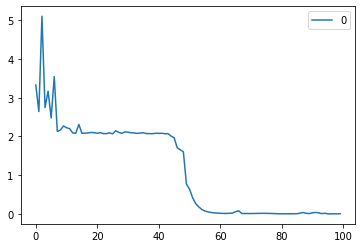

In [75]:
pd.DataFrame(train_curve).plot() # loss曲线